Copied 365 images to the test set.


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Class indices (train): {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Class indices (validation): {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Epoch 1/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 137s 147ms/step - accuracy: 0.2426 - loss: 1.8203 - val_accuracy: 0.2897 - val_loss: 1.7293 - learning_rate: 0.0010
Epoch 2/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 47s 52ms/step - accuracy: 0.2633 - loss: 1.7640 - val_accuracy: 0.3215 - val_loss: 1.6865 - learning_rate: 0.0010
Epoch 3/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - accuracy: 0.2907 - loss: 1.7226 - val_accuracy: 0.3770 - val_loss: 1.5889 - learning_rate: 0.0010
Epoch 4/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.3348 - loss: 1.6556 - val_accuracy: 0.4454 - val_loss: 1.4621 - learning_rate: 0.0010
Epoch 5/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 49s 54ms/step - accuracy: 0.

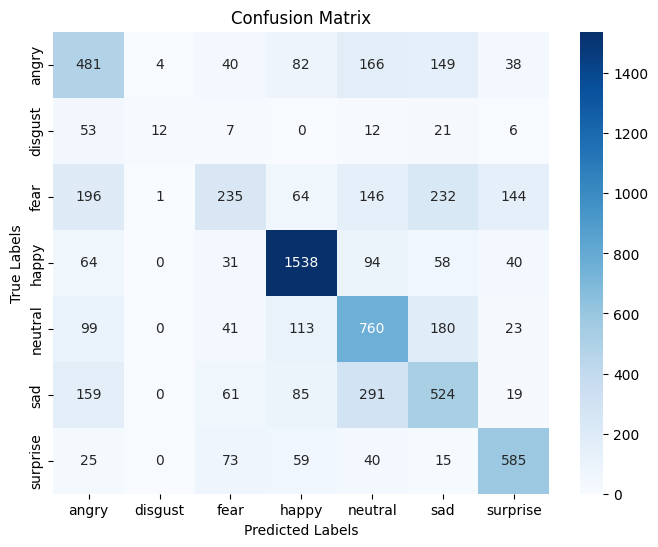

              precision    recall  f1-score   support

       angry       0.45      0.50      0.47       960
     disgust       0.71      0.11      0.19       111
        fear       0.48      0.23      0.31      1018
       happy       0.79      0.84      0.82      1825
     neutral       0.50      0.62      0.56      1216
         sad       0.44      0.46      0.45      1139
    surprise       0.68      0.73      0.71       797

    accuracy                           0.59      7066
   macro avg       0.58      0.50      0.50      7066
weighted avg       0.58      0.59      0.57      7066



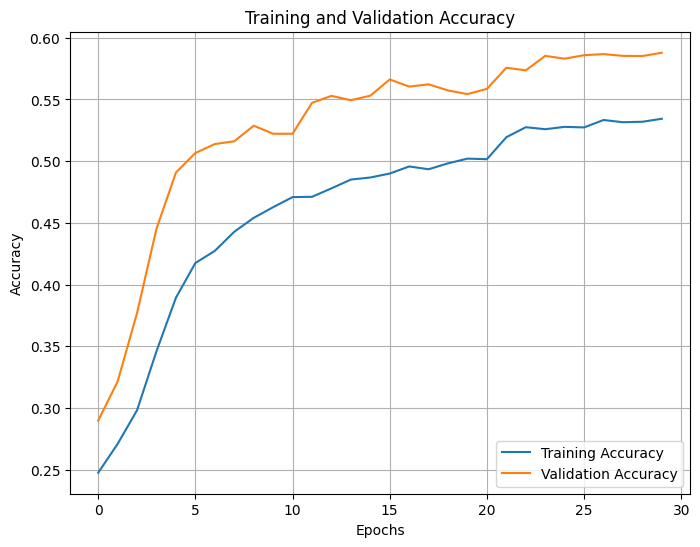

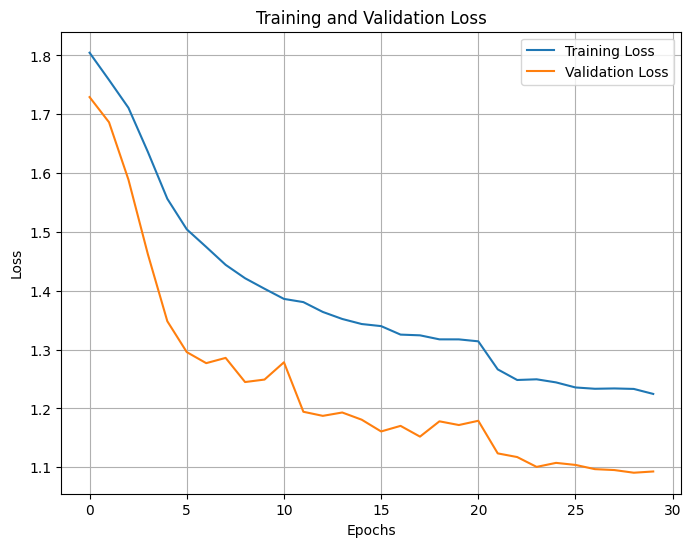

In [7]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define the paths to the dataset
train_dir = '/kaggle/input/face-expression-recognition-dataset/images/train'
validation_dir = '/kaggle/input/face-expression-recognition-dataset/images/validation'

# Define image size and batch size
IMG_SIZE = 48
BATCH_SIZE = 32

# Data augmentation and preprocessing for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of tensor image data from the directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

# Print class indices for sanity check
print("Class indices (train):", train_generator.class_indices)
print("Class indices (validation):", validation_generator.class_indices)

# Define CNN model architecture
model = Sequential()

# Convolutional layers and max pooling
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the 3D output to 1D for the fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(Dense(7, activation='softmax'))  # Output layer for 7 emotion categories

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(train_generator, 
                    epochs=30, 
                    validation_data=validation_generator,
                    callbacks=[early_stopping, reduce_lr, checkpoint])

# Evaluate the model on the validation set
validation_loss, validation_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {validation_acc:.2f}")

# Generate predictions for the validation set
y_true = validation_generator.classes
y_pred = np.argmax(model.predict(validation_generator), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualization of confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report to evaluate precision, recall, F1 score
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.show()

# Plot training and validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()
plt.show()


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Class indices (train): {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Class indices (validation): {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729348249.283874     112 service.cc:145] XLA service 0x7d9434005900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729348249.283942     112 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/901 ━━━━━━━━━━━━━━━━━━━━ 1:06 74ms/step - accuracy: 0.1337 - loss: 1.9330 

I0000 00:00:1729348253.101631     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


901/901 ━━━━━━━━━━━━━━━━━━━━ 170s 182ms/step - accuracy: 0.2435 - loss: 1.8187 - val_accuracy: 0.2901 - val_loss: 1.7449 - learning_rate: 0.0010
Epoch 2/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 45s 49ms/step - accuracy: 0.2697 - loss: 1.7654 - val_accuracy: 0.3239 - val_loss: 1.6716 - learning_rate: 0.0010
Epoch 3/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.3108 - loss: 1.7074 - val_accuracy: 0.3917 - val_loss: 1.5703 - learning_rate: 0.0010
Epoch 4/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.3494 - loss: 1.6366 - val_accuracy: 0.4618 - val_loss: 1.4165 - learning_rate: 0.0010
Epoch 5/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - accuracy: 0.3892 - loss: 1.5448 - val_accuracy: 0.4635 - val_loss: 1.3735 - learning_rate: 0.0010
Epoch 6/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 45s 49ms/step - accuracy: 0.4206 - loss: 1.4877 - val_accuracy: 0.4854 - val_loss: 1.3365 - learning_rate: 0.0010
Epoch 7/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 47s 52ms/step - accuracy: 0.4263 - loss

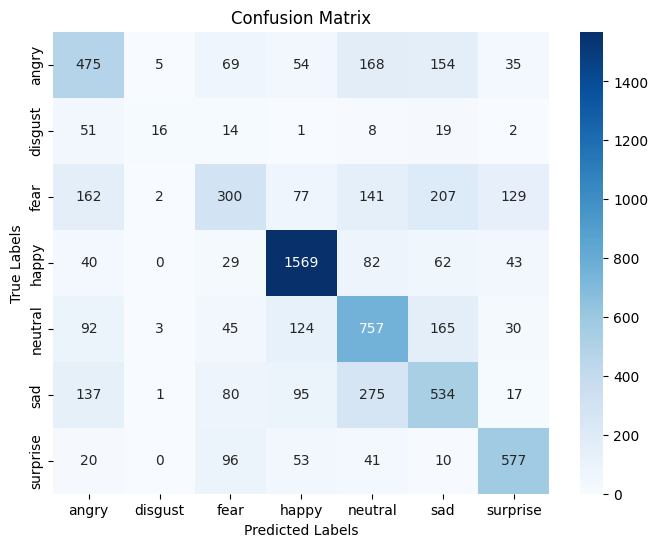

              precision    recall  f1-score   support

       angry       0.49      0.49      0.49       960
     disgust       0.59      0.14      0.23       111
        fear       0.47      0.29      0.36      1018
       happy       0.80      0.86      0.83      1825
     neutral       0.51      0.62      0.56      1216
         sad       0.46      0.47      0.47      1139
    surprise       0.69      0.72      0.71       797

    accuracy                           0.60      7066
   macro avg       0.57      0.52      0.52      7066
weighted avg       0.59      0.60      0.59      7066



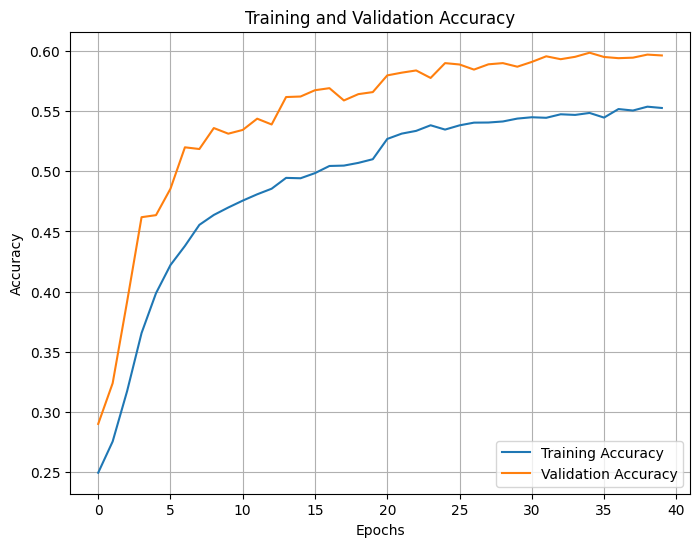

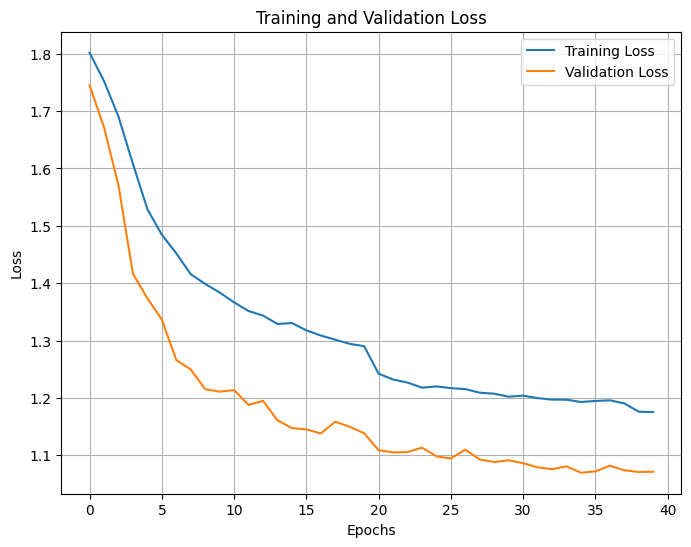

In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define the paths to the dataset
train_dir = '/kaggle/input/face-expression-recognition-dataset/images/train'
validation_dir = '/kaggle/input/face-expression-recognition-dataset/images/validation'

# Define image size and batch size
IMG_SIZE = 48
BATCH_SIZE = 32

# Data augmentation and preprocessing for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of tensor image data from the directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

# Print class indices for sanity check
print("Class indices (train):", train_generator.class_indices)
print("Class indices (validation):", validation_generator.class_indices)

# Build CNN model from scratch
model = Sequential([
    # First convolutional layer
    Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Second convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Third convolutional layer
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the feature maps
    Flatten(),
    
    # Fully connected layers
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(7, activation='softmax')  # 7 output classes for expression classification
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_cnn_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(train_generator, 
                    epochs=100, 
                    validation_data=validation_generator,
                    callbacks=[early_stopping, reduce_lr, checkpoint])

# Evaluate the model on the validation set
validation_loss, validation_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {validation_acc:.2f}")

# Generate predictions for the validation set
y_true = validation_generator.classes
y_pred = np.argmax(model.predict(validation_generator), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualization of confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report to evaluate precision, recall, F1 score
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.show()

# Plot training and validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


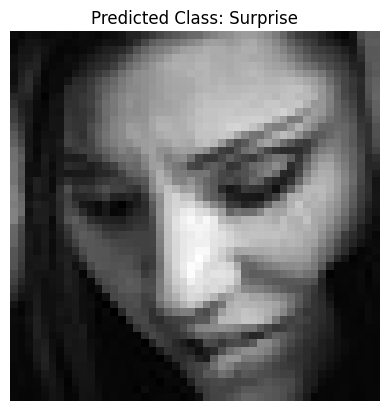

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to predict class of a new image and display it
def predict_image_class(image_path):
    # Load and preprocess the new image as grayscale
    img = image.load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    img_array = image.img_to_array(img)

    # Add batch dimension to match the model's input shape (1, 48, 48, 1)
    img_array = np.expand_dims(img_array, axis=0)  # Shape will be (1, 48, 48, 1)

    # Normalize the image
    img_array /= 255.0  # Rescale

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the predicted class

    # Define class labels (adjust these as per your model)
    class_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
    
    # Display the image and predicted class
    plt.imshow(img_array[0, :, :, 0], cmap='gray')  # Displaying in grayscale
    plt.title(f'Predicted Class: {class_labels[predicted_class]}')
    plt.axis('off')  # Turn off axis labels
    plt.show()  # Show the image

# Example usage
new_image_path = '/kaggle/input/face-expression-recognition-dataset/images/train/fear/10055.jpg'
predict_image_class(new_image_path)


In [5]:
# Save the trained model
model.save('expression_classification_model.h5')


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to predict class of a new image and display it
def predict_image_class(image_path):
    # Load and preprocess the new image as grayscale
    img = image.load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    img_array = image.img_to_array(img)

    # Add batch dimension to match the model's input shape (1, 48, 48, 1)
    img_array = np.expand_dims(img_array, axis=0)  # Shape will be (1, 48, 48, 1)

    # Normalize the image
    img_array /= 255.0  # Rescale

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the predicted class

    # Define class labels (adjust these as per your model)
    class_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
    
    # Display the image and predicted class
    plt.imshow(img_array[0, :, :, 0], cmap='gray')  # Displaying in grayscale
    plt.title(f'Predicted Class: {class_labels[predicted_class]}')
    plt.axis('off')  # Turn off axis labels
    plt.show()  # Show the image

# Example usage
new_image_path = '/kaggle/working/test/disgust/18716.jpg'
predict_image_class(new_image_path)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/test/disgust/18716.jpg'

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the required batch size and target image size based on model expectations
BATCH_SIZE = 32
IMG_SIZE = (48, 48)  # The input size your model expects

# Create an ImageDataGenerator for grayscale images and rescale pixel values
datagen = ImageDataGenerator(rescale=1./255)

# Load images from the '/kaggle/working/test' directory
test_generator = datagen.flow_from_directory(
    '/kaggle/working/test',  # Directory containing the test images
    target_size=IMG_SIZE,     # Resize images to 48x48 (model input size)
    color_mode='grayscale',   # Convert to grayscale images
    batch_size=BATCH_SIZE,    # Set the batch size
    class_mode='categorical', # Assuming you're using categorical classification
    shuffle=False
)

# Load a batch of images
batch_images, batch_labels = next(test_generator)

# Predict on the batch (without flattening)
predictions = model.predict(batch_images)

# Get the predicted classes for the batch
predicted_classes = np.argmax(predictions, axis=1)

# Print the predicted classes
print(predicted_classes)


Found 1411 images belonging to 7 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
[0 3 0 0 0 0 5 0 4 0 0 4 4 0 0 4 5 0 5 0 0 4 4 0 0 5 0 6 0 5 4 0]


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the required batch size and image size
BATCH_SIZE = 32  # You can change this value as needed
IMG_SIZE = (48, 48)  # This should match the input size of your model

# Create an ImageDataGenerator for grayscale images
datagen = ImageDataGenerator(rescale=1./255)  # Rescaling is done to normalize pixel values

# Load images from the '/kaggle/working/test' directory
test_generator = datagen.flow_from_directory(
    '/kaggle/working/test',  # Directory containing the test images
    target_size=IMG_SIZE,  # Resize images to 224x224 (model input size)
    color_mode='grayscale',  # Convert to grayscale images
    batch_size=BATCH_SIZE,  # Set the batch size
    class_mode='categorical',  # Assuming you're using categorical classification
    shuffle=False  # Don't shuffle so predictions can match file order
)

# Now you can iterate over the batches to make predictions
# For example, get the first batch and make predictions
batch_images, batch_labels = next(test_generator)  # Load the first batch of images
predictions = model.predict(batch_images)  # Predict on the batch

# To print predicted classes for the batch
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)


Found 1411 images belonging to 7 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0 3 0 0 0 0 5 0 4 0 0 4 4 0 0 4 5 0 5 0 0 4 4 0 0 5 0 6 0 5 4 0]


In [31]:
print(model.input_shape)


(None, 48, 48, 1)


In [40]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image as grayscale
img_path = '/kaggle/working/test/disgust/12417.jpg'
img = image.load_img(img_path, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))

# Convert the image to a NumPy array
img_array = image.img_to_array(img)

# Check the shape of the image array
print("Image Shape:", img_array.shape)  # Output: (height, width, channels)


Image Shape: (48, 48, 1)


In [39]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# Define the directory containing the images
directory_path = '/kaggle/working/test/disgust'

# Initialize a list to store predictions
predictions_list = []

# Check if the directory exists
if not os.path.exists(directory_path):
    print(f"Directory does not exist: {directory_path}")
else:
    # Iterate over all files in the directory
    for filename in os.listdir(directory_path):
        # Check if the file is an image
        if filename.lower().endswith(('.jpg', '.png')):  
            img_path = os.path.join(directory_path, filename)
            print(f'Processing image: {img_path}')  # Print the current image path
            
            try:
                # Load and preprocess the image as grayscale
                img = image.load_img(img_path, color_mode='grayscale', target_size=(48, 48))
                img_array = image.img_to_array(img)

                # Check the shape of the image array
                print(f'Image shape after loading: {img_array.shape}')  # Should be (48, 48, 1)

                # Add batch dimension to match the model's input shape
                img_array = np.expand_dims(img_array, axis=0)  # Shape will be (1, 48, 48, 1)

                # Normalize the image
                img_array /= 255.0  # Rescale

                # Predict the class
                predictions = model.predict(img_array)
                predicted_class = np.argmax(predictions, axis=1)

                # Store the prediction along with the filename
                predictions_list.append((filename, predicted_class[0]))

            except Exception as e:
                print(f'Error processing {filename}: {e}')

    # Print the predictions for each image
    for filename, predicted_class in predictions_list:
        print(f'Image: {filename}, Predicted Class: {predicted_class}')


Processing image: /kaggle/working/test/disgust/12417.jpg
Image shape after loading: (48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
Processing image: /kaggle/working/test/disgust/14869.jpg
Image shape after loading: (48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Processing image: /kaggle/working/test/disgust/18716.jpg
Image shape after loading: (48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Processing image: /kaggle/working/test/disgust/3101.jpg
Image shape after loading: (48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Processing image: /kaggle/working/test/disgust/533.jpg
Image shape after loading: (48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Processing image: /kaggle/working/test/disgust/1843.jpg
Image shape after loading: (48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Processing image: /kaggle/working/test/disgust/1115.jpg
Image shape after loading: (48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Processing image: /kaggle/working/test/disgust/16054.jpg
Image sha

In [42]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# Define the directory containing the images
directory_path = '/kaggle/working/test/disgust'

# Initialize a list to store predictions
predictions_list = []

# Check if the directory exists
if not os.path.exists(directory_path):
    print(f"Directory does not exist: {directory_path}")
else:
    # Iterate over all files in the directory
    for filename in os.listdir(directory_path):
        # Check if the file is an image
        if filename.lower().endswith(('.jpg', '.png')):  
            img_path = os.path.join(directory_path, filename)
            print(f'Processing image: {img_path}')  # Print the current image path
            
            try:
                # Load and preprocess the image as grayscale
                img = image.load_img(img_path, color_mode='grayscale', target_size=(48, 48))
                img_array = image.img_to_array(img)

                # Check the shape of the image array
                print(f'Image shape after loading: {img_array.shape}')  # Should be (48, 48, 1)

                # Add batch dimension to match the model's input shape (1, 48, 48, 1)
                img_array = np.expand_dims(img_array, axis=0)  # Shape will be (1, 48, 48, 1)

                # Normalize the image
                img_array /= 255.0  # Rescale

                # Predict the class
                predictions = model.predict(img_array)
                predicted_class = np.argmax(predictions, axis=1)

                # Store the prediction along with the filename
                predictions_list.append((filename, predicted_class[0]))

            except Exception as e:
                print(f'Error processing {filename}: {e}')

    # Print the predictions for each image
    for filename, predicted_class in predictions_list:
        print(f'Image: {filename}, Predicted Class: {predicted_class}')


Processing image: /kaggle/working/test/disgust/12417.jpg
Image shape after loading: (48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Processing image: /kaggle/working/test/disgust/14869.jpg
Image shape after loading: (48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Processing image: /kaggle/working/test/disgust/18716.jpg
Image shape after loading: (48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Processing image: /kaggle/working/test/disgust/3101.jpg
Image shape after loading: (48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Processing image: /kaggle/working/test/disgust/533.jpg
Image shape after loading: (48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Processing image: /kaggle/working/test/disgust/1843.jpg
Image shape after loading: (48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Processing image: /kaggle/working/test/disgust/1115.jpg
Image shape after loading: (48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Processing image: /kaggle/working/test/disgust/16054.jpg
Image shap

In [48]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to predict class of a new image
def predict_image_class(image_path):
    # Load and preprocess the new image as grayscale
    img = image.load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    img_array = image.img_to_array(img)

    # Add batch dimension to match the model's input shape (1, 48, 48, 1)
    img_array = np.expand_dims(img_array, axis=0)  # Shape will be (1, 48, 48, 1)

    # Normalize the image
    img_array /= 255.0  # Rescale

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    return predicted_class[0]  # Return the predicted class

# Example usage
new_image_path = '/kaggle/working/test/neutral/21351.jpg'
predicted_class = predict_image_class(new_image_path)
print(f'Predicted Class for {new_image_path}: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Class for /kaggle/working/test/neutral/21351.jpg: 4


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


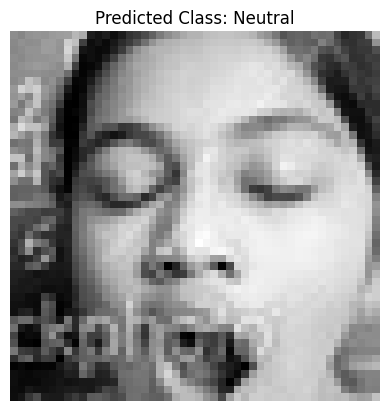

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to predict class of a new image and display it
def predict_image_class(image_path):
    # Load and preprocess the new image as grayscale
    img = image.load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    img_array = image.img_to_array(img)

    # Add batch dimension to match the model's input shape (1, 48, 48, 1)
    img_array = np.expand_dims(img_array, axis=0)  # Shape will be (1, 48, 48, 1)

    # Normalize the image
    img_array /= 255.0  # Rescale

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the predicted class

    # Define class labels (adjust these as per your model)
    class_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
    
    # Display the image and predicted class
    plt.imshow(img_array[0, :, :, 0], cmap='gray')  # Displaying in grayscale
    plt.title(f'Predicted Class: {class_labels[predicted_class]}')
    plt.axis('off')  # Turn off axis labels
    plt.show()  # Show the image

# Example usage
new_image_path = '/kaggle/input/face-expression-recognition-dataset/images/train/neutral/10200.jpg'
predict_image_class(new_image_path)
